In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from copy import deepcopy
import time
import networkx as nx
from matplotlib.collections import LineCollection
import matplotlib.colors as mcolors
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import traceback

# Define the SimpleNet model
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 1024)
        self.fc3 = nn.Linear(1024, 768)
        self.fc4 = nn.Linear(768, 256)
        self.fc5 = nn.Linear(256, 10)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = x.view(-1, 784)  # Flatten the input
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.fc5(x)
        return x

class NeuralNetworkCompressor:
    def __init__(self, model, compression_ratio=0.5, Tmin=0.01, alpha=0.99, 
                 PERTURB=0.0005, STOP=1e-5, T=80, seed=42, device='auto'):
        """
        Initialize the neural network compressor using deterministic annealing.
        
        Args:
            model: PyTorch neural network model
            compression_ratio: Target compression ratio for hidden layers
            Tmin: Minimum temperature for annealing
            alpha: Annealing rate
            PERTURB: Perturbation factor for centroids
            STOP: Convergence threshold
            T: Initial temperature
            seed: Random seed for reproducibility
            device: Device to use ('cuda', 'cpu', or 'auto')
        """
        self.model = deepcopy(model)
        self.compression_ratio = compression_ratio
        self.Tmin = Tmin
        self.alpha = alpha
        self.PERTURB = PERTURB
        self.STOP = STOP
        self.T = T
        self.seed = seed
        np.random.seed(seed)
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(seed)
        
        # Set device
        if device == 'auto':
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        else:
            self.device = torch.device(device)
        
        print(f"Using device: {self.device}")
        
        # Try to move model to device with error handling
        try:
            self.model.to(self.device)
            print("Model successfully moved to device.")
        except Exception as e:
            print(f"Error moving model to device: {e}")
            print("Falling back to CPU.")
            self.device = torch.device("cpu")
            self.model.to(self.device)
        
        # Store original model parameters for comparison
        self.original_params = {name: param.data.clone() for name, param in self.model.named_parameters()}
        self.compressed_params = {}
        self.compression_stats = {}
        self.association_matrices = {}
        self.compressed_model = None
        
    def calculate_distortion(self, X, Y):
        """
        Calculate the squared Euclidean distance between each point in X and each centroid in Y.
        Uses GPU acceleration when available.
        
        Args:
            X (torch.Tensor): Data matrix of shape (M, N)
            Y (torch.Tensor): Centroid matrix of shape (K, N)
            
        Returns:
            torch.Tensor: Distance matrix of shape (M, K)
        """
        X_sum_sq = torch.sum(X**2, dim=1, keepdim=True)
        Y_sum_sq = torch.sum(Y**2, dim=1, keepdim=True).T
        D = X_sum_sq + Y_sum_sq - 2 * X @ Y.T
        return D
    
    def run_deterministic_annealing(self, X, K):
        """
        Run deterministic annealing clustering algorithm on GPU.
        
        Args:
            X (np.ndarray): Data matrix of shape (M, N)
            K (int): Number of clusters
            
        Returns:
            tuple: (centroids Y, association matrix P)
        """
        M, N = X.shape
        
        # Convert to PyTorch tensor and move to device
        try:
            X_tensor = torch.tensor(X, dtype=torch.float32, device=self.device)
        except Exception as e:
            print(f"Error creating tensor on device: {e}")
            print("Falling back to CPU for this operation.")
            X_tensor = torch.tensor(X, dtype=torch.float32, device='cpu')
        
        # Px is the weight for each data point, assuming uniform weights
        Px = torch.full((M, 1), 1 / M, device=X_tensor.device)
        
        # Initialize centroids to the weighted mean of data
        initial_mean = (Px.T @ X_tensor).reshape(1, -1)
        Y = initial_mean.repeat(K, 1)
        
        T = self.T
        while T >= self.Tmin:
            L_old = float('inf')
            while True:
                # Calculate distortion matrix
                D = self.calculate_distortion(X_tensor, Y)
                
                # Calculate probability matrix using softmax
                D_bar = D - torch.min(D, dim=1, keepdim=True).values
                num = torch.exp(-D_bar / T)
                den = torch.sum(num, dim=1, keepdim=True)
                P = num / den
                
                # Update centroids
                Py = P.T @ Px
                Py[Py == 0] = 1e-10  # Avoid division by zero
                Y = (P.T @ (X_tensor * Px)) / Py.reshape(-1, 1)
                
                # Add small random perturbation
                Y += self.PERTURB * torch.rand(*Y.shape, device=Y.device)
                
                # Calculate loss function
                L = -T * (Px.T @ torch.log(torch.sum(torch.exp(-D_bar / T), dim=1, keepdim=True)))
                
                # Check for convergence
                if torch.abs(L - L_old) < self.STOP:
                    break
                    
                L_old = L
                
            # Decrease temperature
            T *= self.alpha
            
        # Convert results back to numpy for compatibility with PyTorch layers
        return Y.cpu().numpy(), P.cpu().numpy()
    
    def compress_layer(self, layer, input_dim=None):
        """
        Compress a single layer using deterministic annealing.
        
        Args:
            layer: PyTorch layer (Linear or Conv2d)
            input_dim: Input dimension for the layer (if needed)
            
        Returns:
            tuple: (compressed_layer, association_matrix)
        """
        if isinstance(layer, nn.Linear):
            return self.compress_linear_layer(layer)
        elif isinstance(layer, nn.Conv2d):
            return self.compress_conv_layer(layer)
        else:
            # For non-compressible layers, return the original layer and identity matrix
            return layer, None
    
    def compress_linear_layer(self, layer):
        """
        Compress a linear layer using deterministic annealing, treating bias as a special neuron.
        """
        # Get weight matrix and bias
        weight_matrix = layer.weight.data.cpu().numpy()  # (out_features, in_features)
        out_features, in_features = weight_matrix.shape
        
        # Create augmented weight matrix including bias as a special neuron
        if layer.bias is not None:
            bias = layer.bias.data.cpu().numpy()  # (out_features,)
            # Add a column for the bias neuron (which always outputs 1)
            augmented_matrix = np.hstack([weight_matrix, bias.reshape(-1, 1)])
        else:
            # If no bias, just use the weight matrix
            augmented_matrix = weight_matrix
        
        # Determine number of clusters based on compression ratio
        K = max(1, int(out_features * self.compression_ratio))
        
        # Run deterministic annealing on the augmented matrix
        centroids, P = self.run_deterministic_annealing(augmented_matrix, K)
        
        # Get the device and dtype from the original layer
        device = layer.weight.device
        dtype = layer.weight.dtype
        
        # Split centroids into weights and bias
        if layer.bias is not None:
            # Last column of centroids represents the bias
            compressed_weights = centroids[:, :-1]
            compressed_bias = centroids[:, -1]
        else:
            compressed_weights = centroids
            compressed_bias = None
        
        # Create compressed linear layer
        compressed_layer = nn.Linear(in_features, K).to(device)
        compressed_layer.weight.data = torch.tensor(compressed_weights, device=device, dtype=dtype)
        
        if compressed_bias is not None:
            compressed_layer.bias.data = torch.tensor(compressed_bias, device=device, dtype=dtype)
        else:
            compressed_layer.bias = None
            
        return compressed_layer, P
        
    def compress_conv_layer(self, layer):
        """
        Compress a convolutional layer using deterministic annealing, treating bias as a special neuron.
        """
        # Get weight tensor and bias
        weight_tensor = layer.weight.data.cpu().numpy()  # (out_channels, in_channels, kernel_h, kernel_w)
        out_channels, in_channels, kernel_h, kernel_w = weight_tensor.shape
        
        # Reshape weight tensor to 2D matrix
        weight_matrix = weight_tensor.reshape(out_channels, -1)  # (out_channels, in_channels * kernel_h * kernel_w)
        
        # Create augmented weight matrix including bias as a special neuron
        if layer.bias is not None:
            bias = layer.bias.data.cpu().numpy()  # (out_channels,)
            # Add a column for the bias neuron (which always outputs 1)
            augmented_matrix = np.hstack([weight_matrix, bias.reshape(-1, 1)])
        else:
            # If no bias, just use the weight matrix
            augmented_matrix = weight_matrix
        
        # Determine number of clusters based on compression ratio
        K = max(1, int(out_channels * self.compression_ratio))
        
        # Run deterministic annealing on the augmented matrix
        centroids, P = self.run_deterministic_annealing(augmented_matrix, K)
        
        # Get the device and dtype from the original layer
        device = layer.weight.device
        dtype = layer.weight.dtype
        
        # Split centroids into weights and bias
        if layer.bias is not None:
            # Last column of centroids represents the bias
            compressed_weights = centroids[:, :-1]
            compressed_bias = centroids[:, -1]
        else:
            compressed_weights = centroids
            compressed_bias = None
        
        # Reshape compressed weights back to tensor form
        compressed_weights_tensor = compressed_weights.reshape(K, in_channels, kernel_h, kernel_w)
        
        # Create compressed convolutional layer
        compressed_layer = nn.Conv2d(
            in_channels=in_channels,
            out_channels=K,
            kernel_size=layer.kernel_size,
            stride=layer.stride,
            padding=layer.padding,
            dilation=layer.dilation,
            groups=layer.groups,
            bias=(compressed_bias is not None)
        ).to(device)
        
        compressed_layer.weight.data = torch.tensor(compressed_weights_tensor, device=device, dtype=dtype)
        
        if compressed_bias is not None:
            compressed_layer.bias.data = torch.tensor(compressed_bias, device=device, dtype=dtype)
        else:
            compressed_layer.bias = None
            
        return compressed_layer, P
    
    def compress_model(self):
        """
        Compress the entire neural network model, adjusting subsequent layers.
        """
        compressed_model = deepcopy(self.model)
        
        # Try to move compressed model to device with error handling
        try:
            compressed_model.to(self.device)
            print("Compressed model successfully moved to device.")
        except Exception as e:
            print(f"Error moving compressed model to device: {e}")
            print("Falling back to CPU.")
            self.device = torch.device("cpu")
            compressed_model.to(self.device)
            self.model.to(self.device)
        
        self.association_matrices = {}
        prev_P = None
        prev_layer_name = None
        
        # Get a list of all modules in the model
        modules = list(compressed_model.named_modules())
        
        # First pass: identify compressible layers (excluding input and output layers)
        # Collect all linear and conv layers
        linear_conv_layers = []
        for name, module in modules:
            if isinstance(module, (nn.Linear, nn.Conv2d)):
                linear_conv_layers.append((name, module))
        
        # The first layer is the input layer, the last layer is the output layer
        input_layer_name = linear_conv_layers[0][0]
        output_layer_name = linear_conv_layers[-1][0]
        
        print(f"Input layer: {input_layer_name}")
        print(f"Output layer: {output_layer_name}")
        
        # Second pass: compress layers and adjust dimensions
        for name, module in modules:
            if isinstance(module, (nn.Linear, nn.Conv2d)):
                # Get parent module and attribute name
                path = name.split('.')
                parent = compressed_model
                for p in path[:-1]:
                    parent = getattr(parent, p)
                attr_name = path[-1]
                layer = getattr(parent, attr_name)
                
                # If this layer follows a compressed layer, adjust its input dimensions
                if prev_P is not None:
                    # Convert P to tensor and move to device
                    try:
                        P_tensor = torch.tensor(prev_P, dtype=torch.float32, device=self.device)
                    except Exception as e:
                        print(f"Error creating P tensor on device: {e}")
                        print("Falling back to CPU for this operation.")
                        P_tensor = torch.tensor(prev_P, dtype=torch.float32, device='cpu')
                    
                    if isinstance(layer, nn.Linear):
                        # Adjust input dimensions for linear layer
                        original_weight = layer.weight.data
                        new_weight = original_weight @ P_tensor
                        
                        # Create new linear layer with adjusted input dimensions
                        new_in_features = prev_P.shape[1]
                        new_layer = nn.Linear(new_in_features, layer.out_features, bias=(layer.bias is not None))
                        new_layer.to(self.device)
                        new_layer.weight.data = new_weight
                        
                        if layer.bias is not None:
                            new_layer.bias.data = layer.bias.data.clone()
                        
                        # Replace the layer
                        setattr(parent, attr_name, new_layer)
                        layer = new_layer
                    
                    elif isinstance(layer, nn.Conv2d):
                        # Adjust input dimensions for conv layer
                        original_weight = layer.weight.data
                        out_channels, in_channels, kernel_h, kernel_w = original_weight.shape
                        
                        # Reshape weight matrix for multiplication
                        weight_matrix = original_weight.reshape(out_channels, -1)
                        new_weight_matrix = weight_matrix @ P_tensor
                        new_weight_tensor = new_weight_matrix.reshape(out_channels, prev_P.shape[1], kernel_h, kernel_w)
                        
                        # Create new conv layer with adjusted input dimensions
                        new_layer = nn.Conv2d(
                            in_channels=prev_P.shape[1],
                            out_channels=out_channels,
                            kernel_size=layer.kernel_size,
                            stride=layer.stride,
                            padding=layer.padding,
                            dilation=layer.dilation,
                            groups=layer.groups,
                            bias=(layer.bias is not None)
                        )
                        new_layer.to(self.device)
                        new_layer.weight.data = new_weight_tensor
                        
                        if layer.bias is not None:
                            new_layer.bias.data = layer.bias.data.clone()
                        
                        # Replace the layer
                        setattr(parent, attr_name, new_layer)
                        layer = new_layer
                
                # Compress the current layer if it's compressible (not input or output layer)
                if name != input_layer_name and name != output_layer_name:
                    compressed_layer, P = self.compress_layer(layer)
                    setattr(parent, attr_name, compressed_layer)
                    
                    # Store the association matrix for the next layer
                    prev_P = P
                    self.association_matrices[name] = P
                    print(f"Compressed layer {name}: {layer} -> {compressed_layer}")
                else:
                    # Reset prev_P for non-compressible layers
                    prev_P = None
                    print(f"Skipped layer {name} (input/output layer)")
        
        # Store compressed parameters and stats
        self.compressed_params = {name: param.data.clone() for name, param in compressed_model.named_parameters()}
        self.calculate_compression_stats()
        
        # Store the compressed model
        self.compressed_model = compressed_model
        
        return compressed_model
    
    def calculate_compression_stats(self):
        """
        Calculate and store compression statistics.
        """
        original_params = sum(p.numel() for p in self.original_params.values())
        compressed_params = sum(p.numel() for p in self.compressed_params.values())
        
        self.compression_stats = {
            'original_parameters': original_params,
            'compressed_parameters': compressed_params,
            'compression_ratio': 1 - (compressed_params / original_params),
            'parameter_reduction': original_params - compressed_params
        }
    
    def evaluate_model(self, model, test_loader):
        """
        Evaluate the model on a test dataset using GPU.
        
        Args:
            model: PyTorch model to evaluate
            test_loader: DataLoader for test dataset
            
        Returns:
            dict: Dictionary containing evaluation metrics
        """
        model.eval()
        model.to(self.device)
        
        correct = 0
        total = 0
        loss = 0.0
        criterion = nn.CrossEntropyLoss().to(self.device)
        
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()
                loss += criterion(outputs, targets).item() * inputs.size(0)
        
        accuracy = 100 * correct / total
        avg_loss = loss / total
        
        return {
            'accuracy': accuracy,
            'loss': avg_loss
        }
    
    def compare_models(self, test_loader):
        """
        Compare the original and compressed models on a test dataset using GPU.
        
        Args:
            test_loader: DataLoader for test dataset
            
        Returns:
            dict: Dictionary containing comparison metrics
        """
        # Evaluate original model
        original_results = self.evaluate_model(self.model, test_loader)
        
        # Evaluate compressed model
        if self.compressed_model is None:
            compressed_model = self.compress_model()
        else:
            compressed_model = self.compressed_model
            
        compressed_results = self.evaluate_model(compressed_model, test_loader)
        
        # Calculate differences
        accuracy_diff = original_results['accuracy'] - compressed_results['accuracy']
        loss_diff = compressed_results['loss'] - original_results['loss']
        
        return {
            'original_accuracy': original_results['accuracy'],
            'compressed_accuracy': compressed_results['accuracy'],
            'accuracy_difference': accuracy_diff,
            'original_loss': original_results['loss'],
            'compressed_loss': compressed_results['loss'],
            'loss_difference': loss_diff,
            **self.compression_stats
        }
    
    def visualize_compression(self, layer_name=None):
        """
        Visualize the compression of a specific layer or the entire model.
        
        Args:
            layer_name: Name of the layer to visualize (if None, visualize all layers)
        """
        if layer_name:
            # Visualize a specific layer
            if layer_name in self.original_params and layer_name in self.compressed_params:
                original_weights = self.original_params[layer_name].cpu().numpy()
                compressed_weights = self.compressed_params[layer_name].cpu().numpy()
                
                plt.figure(figsize=(12, 6))
                
                plt.subplot(1, 2, 1)
                plt.imshow(original_weights, cmap='viridis')
                plt.title(f'Original Weights - {layer_name}')
                plt.colorbar()
                
                plt.subplot(1, 2, 2)
                plt.imshow(compressed_weights, cmap='viridis')
                plt.title(f'Compressed Weights - {layer_name}')
                plt.colorbar()
                
                plt.tight_layout()
                plt.show()
            else:
                print(f"Layer {layer_name} not found in model parameters.")
        else:
            # Visualize compression statistics
            stats = self.compression_stats
            if stats:
                plt.figure(figsize=(10, 6))
                
                plt.subplot(1, 2, 1)
                categories = ['Original', 'Compressed']
                values = [stats['original_parameters'], stats['compressed_parameters']]
                plt.bar(categories, values)
                plt.title('Parameter Count')
                plt.ylabel('Number of Parameters')
                
                plt.subplot(1, 2, 2)
                plt.pie([stats['compression_ratio'], 1 - stats['compression_ratio']], 
                        labels=['Compressed', 'Remaining'], autopct='%1.1f%%')
                plt.title('Compression Ratio')
                
                plt.tight_layout()
                plt.show()
    
    def model_to_graph(self, model):
        """
        Convert a neural network model to a graph representation.
        Includes bias neurons as special nodes.
        Creates all edges without filtering by weight.
        
        Args:
            model: PyTorch model
            
        Returns:
            tuple: (networkx.DiGraph, dict) - Graph and node positions
        """
        G = nx.DiGraph()
        node_positions = {}
        layer_counts = {}
        layer_nodes = {}
        
        # First pass: count nodes per layer
        for name, module in model.named_modules():
            if isinstance(module, (nn.Linear, nn.Conv2d)):
                if isinstance(module, nn.Linear):
                    layer_counts[name] = module.out_features
                else:  # Conv2d
                    layer_counts[name] = module.out_features
        
        # Print layer information for debugging
        print("\nLayer information for model:")
        for name, count in layer_counts.items():
            print(f"{name}: {count} nodes")
        
        # Second pass: create nodes and edges
        layer_idx = 0
        for name, module in model.named_modules():
            if isinstance(module, (nn.Linear, nn.Conv2d)):
                # Create nodes for this layer
                nodes = []
                if isinstance(module, nn.Linear):
                    num_nodes = module.out_features
                else:  # Conv2d
                    num_nodes = module.out_features
                
                for i in range(num_nodes):
                    node_id = f"{name}_{i}"
                    G.add_node(node_id, layer=name, index=i, type='neuron')
                    nodes.append(node_id)
                    
                    # Position nodes in a grid
                    x = layer_idx * 2
                    y = (i - num_nodes/2) * 0.5
                    node_positions[node_id] = (x, y)
                
                # Add bias neuron for this layer
                bias_node_id = f"{name}_bias"
                G.add_node(bias_node_id, layer=name, type='bias')
                nodes.append(bias_node_id)
                
                # Position bias neuron
                x_bias = layer_idx * 2
                y_bias = (num_nodes/2 + 1) * 0.5
                node_positions[bias_node_id] = (x_bias, y_bias)
                
                layer_nodes[name] = nodes
                layer_idx += 1
        
        # Create edges between consecutive layers
        layer_names = list(layer_nodes.keys())
        print(f"\nLayer names: {layer_names}")
        
        for i in range(len(layer_names) - 1):
            current_layer = layer_names[i]
            next_layer = layer_names[i+1]
            
            print(f"\nCreating edges from {current_layer} to {next_layer}")
            
            current_module = dict(model.named_modules())[current_layer]
            
            if isinstance(current_module, nn.Linear):
                weights = current_module.weight.data.cpu().numpy()
                bias = current_module.bias.data.cpu().numpy() if current_module.bias is not None else None
                
                print(f"Weight matrix shape: {weights.shape}")
                print(f"Max absolute weight: {np.max(np.abs(weights))}")
                
                # Connect regular neurons (all edges, no threshold)
                for j, next_node in enumerate(layer_nodes[next_layer]):
                    if next_node.endswith('_bias'):
                        continue  # Skip bias nodes in next layer
                    for k, current_node in enumerate(layer_nodes[current_layer]):
                        if current_node.endswith('_bias'):
                            continue  # Skip bias nodes in current layer
                        # Check if indices are within bounds
                        if j < weights.shape[0] and k < weights.shape[1]:
                            weight = weights[j, k]
                            # Add all edges regardless of weight
                            G.add_edge(current_node, next_node, weight=weight)
                
                # Connect bias neurons (all edges, no threshold)
                if bias is not None:
                    print(f"Bias shape: {bias.shape}")
                    print(f"Max absolute bias: {np.max(np.abs(bias))}")
                    
                    for j, next_node in enumerate(layer_nodes[next_layer]):
                        if next_node.endswith('_bias'):
                            continue  # Skip bias nodes in next layer
                        if j < bias.shape[0]:
                            bias_weight = bias[j]
                            # Add all edges regardless of weight
                            bias_node = f"{current_layer}_bias"
                            G.add_edge(bias_node, next_node, weight=bias_weight)
            
            elif isinstance(current_module, nn.Conv2d):
                weights = current_module.weight.data.cpu().numpy()
                bias = current_module.bias.data.cpu().numpy() if current_module.bias is not None else None
                out_channels, in_channels, kernel_h, kernel_w = weights.shape
                
                print(f"Weight tensor shape: {weights.shape}")
                print(f"Max absolute weight: {np.max(np.abs(weights))}")
                
                # Connect regular neurons (all edges, no threshold)
                for j, next_node in enumerate(layer_nodes[next_layer]):
                    if next_node.endswith('_bias'):
                        continue  # Skip bias nodes in next layer
                    for k, current_node in enumerate(layer_nodes[current_layer]):
                        if current_node.endswith('_bias'):
                            continue  # Skip bias nodes in current layer
                        # Check if indices are within bounds
                        if j < weights.shape[0] and k < weights.shape[1]:
                            # Calculate average weight for this connection
                            avg_weight = np.mean(weights[j, k])
                            # Add all edges regardless of weight
                            G.add_edge(current_node, next_node, weight=avg_weight)
                
                # Connect bias neurons (all edges, no threshold)
                if bias is not None:
                    print(f"Bias shape: {bias.shape}")
                    print(f"Max absolute bias: {np.max(np.abs(bias))}")
                    
                    for j, next_node in enumerate(layer_nodes[next_layer]):
                        if next_node.endswith('_bias'):
                            continue  # Skip bias nodes in next layer
                        if j < bias.shape[0]:
                            bias_weight = bias[j]
                            # Add all edges regardless of weight
                            bias_node = f"{current_layer}_bias"
                            G.add_edge(bias_node, next_node, weight=bias_weight)
        
        print(f"\nGraph created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
        return G, node_positions
    
    def draw_neural_network(self, G, pos, title="Neural Network", 
                           edge_percentage=0.01, min_edges=100, max_edges=5000,
                           min_alpha=0.1, max_width=3.0, min_width=0.5):
        """
        Draw a neural network graph with a subset of the most important edges.
        Bias neurons are shown in a different color.
        Only draws a percentage of the edges with the highest absolute weights.
        
        Args:
            G: NetworkX graph
            pos: Dictionary of node positions
            title: Title for the plot
            edge_percentage: Percentage of edges to draw (0-1)
            min_edges: Minimum number of edges to draw
            max_edges: Maximum number of edges to draw
            min_alpha: Minimum opacity for edges (smallest weights)
            max_width: Maximum width for edges (largest weights)
            min_width: Minimum width for edges (smallest weights)
        """
        # Start timing
        start_time = time.time()
        
        plt.figure(figsize=(14, 10))
        
        # Extract edge weights
        edges = list(G.edges())
        weights = [G[u][v]['weight'] for u, v in edges]
        
        # Calculate absolute weights
        abs_weights = [abs(w) for w in weights]
        
        # Determine number of edges to draw
        total_edges = len(edges)
        num_edges_to_draw = max(min_edges, min(int(total_edges * edge_percentage), max_edges))
        print(f"Drawing {num_edges_to_draw} out of {total_edges} edges ({num_edges_to_draw/total_edges*100:.1f}%)")
        
        # Sort edges by absolute weight in descending order
        edge_weight_pairs = list(zip(edges, abs_weights, weights))
        edge_weight_pairs.sort(key=lambda x: x[1], reverse=True)
        
        # Select the top edges
        selected_edges = edge_weight_pairs[:num_edges_to_draw]
        
        # Extract selected edges and their weights
        selected_edge_list = [e[0] for e in selected_edges]
        selected_abs_weights = [e[1] for e in selected_edges]
        selected_weights = [e[2] for e in selected_edges]
        
        # Normalize weights for edge width and opacity
        if selected_abs_weights:
            max_weight = max(selected_abs_weights) if max(selected_abs_weights) > 0 else 1
            
            # Normalize to [0,1] range
            normalized_weights = [w / max_weight for w in selected_abs_weights]
            
            # Calculate edge widths (min_width to max_width)
            edge_widths = [min_width + (max_width - min_width) * nw for nw in normalized_weights]
            
            # Calculate edge opacity (min_alpha to 1.0)
            edge_alphas = [min_alpha + (1.0 - min_alpha) * nw for nw in normalized_weights]
        else:
            normalized_weights = [0] * len(selected_edge_list)
            edge_widths = [min_width] * len(selected_edge_list)
            edge_alphas = [min_alpha] * len(selected_edge_list)
        
        # Create a colormap for edges based on sign
        edge_colors = []
        for weight in selected_weights:
            if weight > 0:
                edge_colors.append('blue')
            else:
                edge_colors.append('red')
        
        # Draw regular neurons
        regular_nodes = [node for node in G.nodes() if G.nodes[node].get('type') != 'bias']
        nx.draw_networkx_nodes(G, pos, nodelist=regular_nodes, node_size=200, node_color='lightgreen', alpha=0.8)
        
        # Draw bias neurons in a different color
        bias_nodes = [node for node in G.nodes() if G.nodes[node].get('type') == 'bias']
        nx.draw_networkx_nodes(G, pos, nodelist=bias_nodes, node_size=200, node_color='lightblue', alpha=0.8)
        
        # Draw edges individually to set different alpha values
        for i, (u, v) in enumerate(selected_edge_list):
            nx.draw_networkx_edges(
                G, pos, 
                edgelist=[(u, v)], 
                width=edge_widths[i], 
                edge_color=edge_colors[i],
                alpha=edge_alphas[i],
                arrows=True,
                arrowsize=10
            )
        
        # Add labels for layers
        layer_positions = {}
        for node, data in G.nodes(data=True):
            layer = data.get('layer', '')
            if layer not in layer_positions:
                layer_positions[layer] = []
            layer_positions[layer].append(pos[node])
        
        for layer, positions in layer_positions.items():
            if positions:
                x = np.mean([p[0] for p in positions])
                y = max([p[1] for p in positions]) + 0.8
                plt.text(x, y, layer, ha='center', fontsize=12, fontweight='bold')
        
        plt.title(title, fontsize=16)
        plt.axis('off')
        plt.tight_layout()
        
        # End timing and print duration
        end_time = time.time()
        duration = end_time - start_time
        print(f"Graph drawing took {duration:.2f} seconds")
        
        plt.show()
        
        return duration
    
    def visualize_networks(self, edge_percentage=0.01, min_edges=100, max_edges=5000,
                          min_alpha=0.1, max_width=3.0, min_width=0.5):
        """
        Visualize both the original and compressed neural networks.
        Includes bias neurons as special nodes.
        Only draws a percentage of the edges with the highest absolute weights.
        
        Args:
            edge_percentage: Percentage of edges to draw (0-1)
            min_edges: Minimum number of edges to draw
            max_edges: Maximum number of edges to draw
            min_alpha: Minimum opacity for edges (smallest weights)
            max_width: Maximum width for edges (largest weights)
            min_width: Minimum width for edges (smallest weights)
        """
        # Create compressed model if not already created
        if self.compressed_model is None:
            self.compress_model()
        
        # Convert models to graphs
        try:
            print("Creating graph for original model...")
            original_graph, original_pos = self.model_to_graph(self.model)
        except Exception as e:
            print(f"Error creating graph for original model: {e}")
            traceback.print_exc()
            return
        
        try:
            print("Creating graph for compressed model...")
            compressed_graph, compressed_pos = self.model_to_graph(self.compressed_model)
        except Exception as e:
            print(f"Error creating graph for compressed model: {e}")
            traceback.print_exc()
            return
        
        # Draw original network
        try:
            print("Drawing original network...")
            original_duration = self.draw_neural_network(
                original_graph, 
                original_pos, 
                title="Original Neural Network",
                edge_percentage=edge_percentage,
                min_edges=min_edges,
                max_edges=max_edges,
                min_alpha=min_alpha,
                max_width=max_width,
                min_width=min_width
            )
        except Exception as e:
            print(f"Error drawing original network: {e}")
            traceback.print_exc()
            original_duration = 0
        
        # Draw compressed network
        try:
            print("Drawing compressed network...")
            compressed_duration = self.draw_neural_network(
                compressed_graph, 
                compressed_pos, 
                title="Compressed Neural Network",
                edge_percentage=edge_percentage,
                min_edges=min_edges,
                max_edges=max_edges,
                min_alpha=min_alpha,
                max_width=max_width,
                min_width=min_width
            )
        except Exception as e:
            print(f"Error drawing compressed network: {e}")
            traceback.print_exc()
            compressed_duration = 0
        
        # Print compression statistics
        print("\nCompression Statistics:")
        for key, value in self.compression_stats.items():
            print(f"{key}: {value}")
        
        # Print timing statistics
        print("\nTiming Statistics:")
        print(f"Original graph drawing time: {original_duration:.2f} seconds")
        print(f"Compressed graph drawing time: {compressed_duration:.2f} seconds")
        print(f"Total drawing time: {original_duration + compressed_duration:.2f} seconds")

Using device: cuda


100%|██████████| 9.91M/9.91M [00:00<00:00, 41.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 996kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.60MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.71MB/s]


Model successfully created and moved to device.
Model loaded and ready for inference.

Original model architecture:
fc1.weight: torch.Size([512, 784])
fc1.bias: torch.Size([512])
fc2.weight: torch.Size([1024, 512])
fc2.bias: torch.Size([1024])
fc3.weight: torch.Size([768, 1024])
fc3.bias: torch.Size([768])
fc4.weight: torch.Size([256, 768])
fc4.bias: torch.Size([256])
fc5.weight: torch.Size([10, 256])
fc5.bias: torch.Size([10])

Original Model Accuracy: 97.99%
Using device: cuda
Model successfully moved to device.
Compressed model successfully moved to device.
Input layer: fc1
Output layer: fc5
Skipped layer fc1 (input/output layer)
Compressed layer fc2: Linear(in_features=512, out_features=1024, bias=True) -> Linear(in_features=512, out_features=102, bias=True)
Compressed layer fc3: Linear(in_features=102, out_features=768, bias=True) -> Linear(in_features=102, out_features=76, bias=True)
Compressed layer fc4: Linear(in_features=76, out_features=256, bias=True) -> Linear(in_features=7

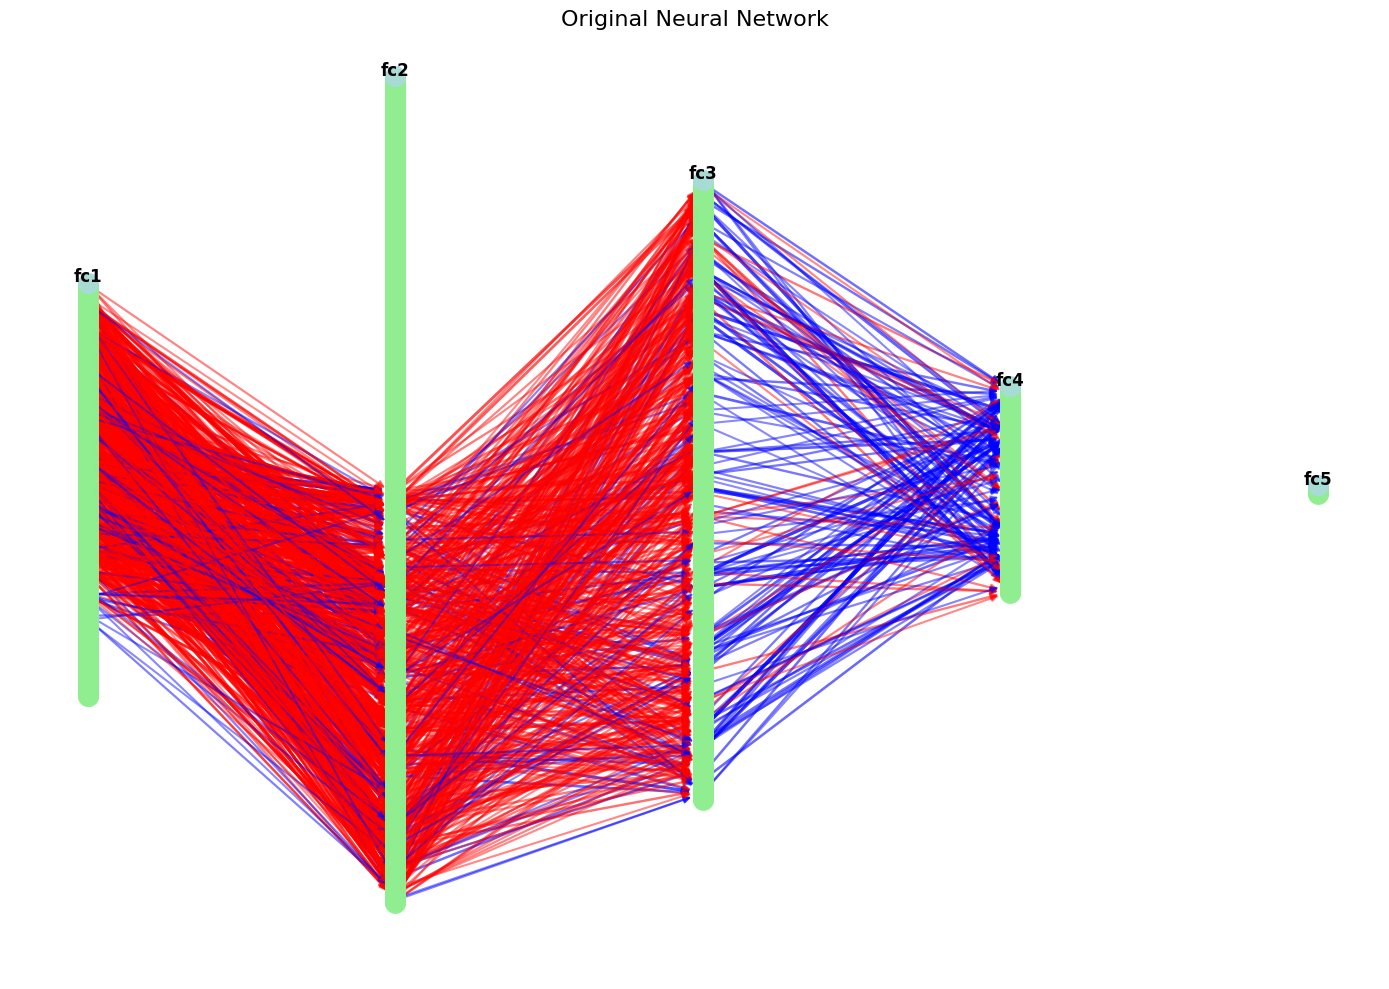

Drawing compressed network...
Drawing 311 out of 62339 edges (0.5%)
Graph drawing took 1.24 seconds


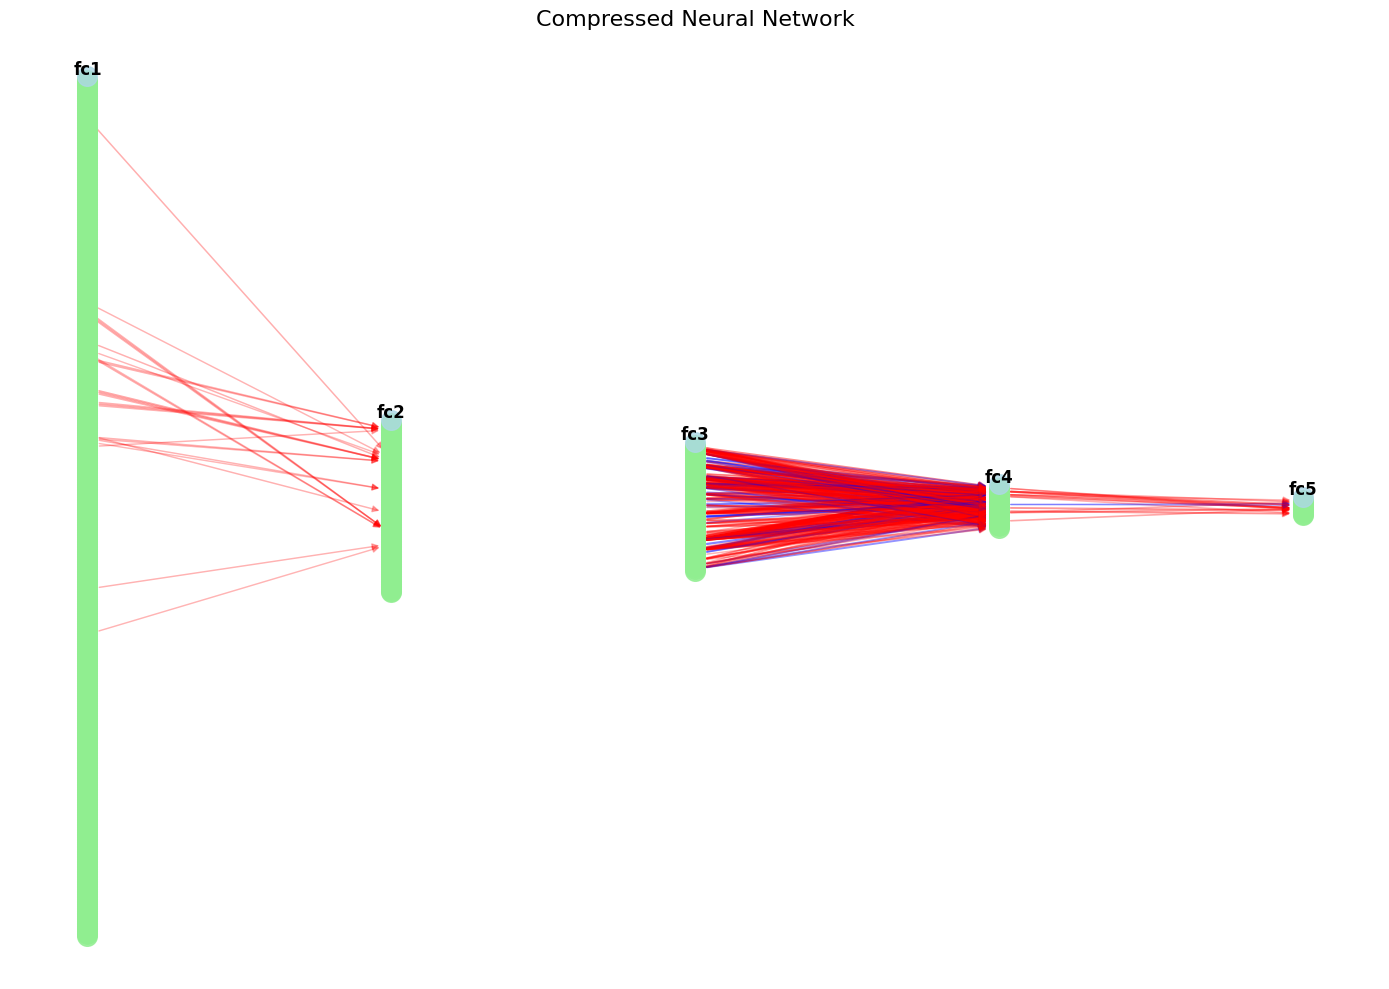


Compression Statistics:
original_parameters: 1913866
compressed_parameters: 464259
compression_ratio: 0.7574234559786317
parameter_reduction: 1449607

Timing Statistics:
Original graph drawing time: 10.47 seconds
Compressed graph drawing time: 1.24 seconds
Total drawing time: 11.71 seconds


In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Recreate the model architecture
try:
    model = SimpleNet().to(device)
    print("Model successfully created and moved to device.")
except Exception as e:
    print(f"Error creating model: {e}")
    traceback.print_exc()
    # If CUDA fails, try with CPU
    device = torch.device("cpu")
    model = SimpleNet().to(device)
    print(f"Falling back to CPU device: {device}")

# Load the saved weights
try:
    model.load_state_dict(torch.load("/kaggle/input/trained-nn-model/simplenet_mnist.pth", map_location=device))
    print("Model loaded and ready for inference.")
except Exception as e:
    print(f"Error loading model weights: {e}")
    traceback.print_exc()
    exit(1)

# Print original model architecture
print("\nOriginal model architecture:")
for name, param in model.named_parameters():
    print(f"{name}: {param.shape}")

# Evaluate original model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

print(f'\nOriginal Model Accuracy: {100 * correct / total:.2f}%')

# Create compressor with CUDA support
try:
    compressor = NeuralNetworkCompressor(model, compression_ratio=0.1, device=device)
except Exception as e:
    print(f"Error creating compressor: {e}")
    traceback.print_exc()
    # If CUDA fails, try with CPU
    device = torch.device("cpu")
    compressor = NeuralNetworkCompressor(model, compression_ratio=0.1, device=device)

# Compress the model
try:
    compressed_model = compressor.compress_model()
    print("Compressed model created and stored.")
except Exception as e:
    print(f"Error during compression: {e}")
    traceback.print_exc()
    exit(1)

# Print compressed model architecture
print("\nCompressed model architecture:")
for name, param in compressed_model.named_parameters():
    print(f"{name}: {param.shape}")

# Evaluate the compressed model
compressed_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        outputs = compressed_model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

print(f'\nCompressed Model Accuracy: {100 * correct / total:.2f}%')

# Compare models
try:
    comparison = compressor.compare_models(test_loader)
    print("\nCompression Statistics:")
    for key, value in comparison.items():
        print(f"{key}: {value}")
except Exception as e:
    print(f"Error during model comparison: {e}")
    traceback.print_exc()

# Visualize compression with optimized edge sampling
try:
    # For large graphs, use a smaller percentage of edges
    compressor.visualize_networks(
        edge_percentage=0.005,  # 0.5% of edges
        min_edges=100,        # At least 100 edges
        max_edges=2000,       # At most 2000 edges
        min_alpha=0.1,        # Minimum opacity
        max_width=3.0,        # Maximum edge width
        min_width=0.5         # Minimum edge width
    )
except Exception as e:
    print(f"Error during visualization: {e}")
    traceback.print_exc()

In [3]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import torchvision
# import torchvision.transforms as transforms
# from torch.utils.data import DataLoader

# # Define a simple neural network for demonstration
# class SimpleNet(nn.Module):
#     def __init__(self):
#         super(SimpleNet, self).__init__()
#         self.fc1 = nn.Linear(784, 512)
#         self.fc2 = nn.Linear(512, 1024)
#         self.fc3 = nn.Linear(1024, 768)
#         self.fc4 = nn.Linear(768, 256)
#         self.fc5 = nn.Linear(256, 10)
#         self.relu = nn.ReLU()
        
#     def forward(self, x):
#         x = x.view(-1, 784)  # Flatten the input
#         x = self.relu(self.fc1(x))
#         x = self.relu(self.fc2(x))
#         x = self.relu(self.fc3(x))
#         x = self.relu(self.fc4(x))
#         x = self.fc5(x)
#         return x

# # Load MNIST dataset
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.1307,), (0.3081,))
# ])

# train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# # Train the original model
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = SimpleNet().to(device)
# criterion = nn.CrossEntropyLoss().to(device)
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Training loop
# num_epochs = 5
# for epoch in range(num_epochs):
#     model.train()
#     for batch_idx, (data, target) in enumerate(train_loader):
#         data, target = data.to(device), target.to(device)
#         optimizer.zero_grad()
#         output = model(data)
#         loss = criterion(output, target)
#         loss.backward()
#         optimizer.step()
    
#     print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')


# torch.save(model.state_dict(), "simplenet_mnist.pth")
# print("Model saved")
